# Predictive model for classification

In [1]:
import pandas as pd

DATA = "../data/customers_clustered_pca.csv"

df_clustered = pd.read_csv(DATA)

df_clustered.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,2
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,2
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,0


In [2]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2205 non-null   object 
 1   Marital_Status       2205 non-null   object 
 2   Income               2205 non-null   float64
 3   Kidhome              2205 non-null   int64  
 4   Teenhome             2205 non-null   int64  
 5   Recency              2205 non-null   int64  
 6   MntWines             2205 non-null   int64  
 7   MntFruits            2205 non-null   int64  
 8   MntMeatProducts      2205 non-null   int64  
 9   MntFishProducts      2205 non-null   int64  
 10  MntSweetProducts     2205 non-null   int64  
 11  MntGoldProds         2205 non-null   int64  
 12  NumDealsPurchases    2205 non-null   int64  
 13  NumWebPurchases      2205 non-null   int64  
 14  NumCatalogPurchases  2205 non-null   int64  
 15  NumStorePurchases    2205 non-null   i

In [3]:
X = df_clustered.drop('Response', axis=1)
y = df_clustered['Response']

In [4]:
X.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,2
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,2
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,0


In [5]:
y

0       1
1       0
2       0
3       0
4       0
       ..
2200    0
2201    0
2202    0
2203    0
2204    1
Name: Response, Length: 2205, dtype: int64

In [6]:
one_hot_cols = [
    'Education',
    'Marital_Status',
    'AgeGroup',
    'HasChildren',
    'HasAcceptedCmp',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'Complain',
    'Kidhome',
    'Teenhome',
    'YearsSinceEnrolled',
    'Children',
    'AcceptedCmpTotal',
    'cluster'
]

standard_cols = [
    'Income',
    'Age',
]

power_cols = X.columns[X.columns.str.startswith('Mnt') | X.columns.str.startswith('Num')].tolist()

minmax_cols = [col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols]

https://scikit-learn.org/0.16/modules/generated/sklearn.dummy.DummyClassifier.html

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline # essa será a bibliota usada para o pipeline
from imblearn.under_sampling import RandomUnderSampler

RANDOM_STATE = 42

models = {
    'DummyClassifier': DummyClassifier(strategy='stratified', random_state=RANDOM_STATE),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE),
    'KNNClassifier': KNeighborsClassifier(n_neighbors=5)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def pipeline_model(X, y, model, kf):

    preprocessing = ColumnTransformer(
        [
            ('one-hot', OneHotEncoder(), one_hot_cols),
            ('standard', StandardScaler(), standard_cols),
            ('minmax', MinMaxScaler(), minmax_cols),
            ('power', PowerTransformer(), power_cols)
        ]
    )

    pipeline = Pipeline(
        [
            ('preprocessing', preprocessing),
            ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
            ('rus', RandomUnderSampler(random_state=RANDOM_STATE)),
            ('model', model)
        ]
    )

    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'],
        n_jobs = -1
    )

    return scores

In [14]:
results = {
    'DummyClassifier': pipeline_model(X, y, models['DummyClassifier'], skf),
    'DecisionTreeClassifier': pipeline_model(X, y, models['DecisionTreeClassifier'], skf),
    'LogisticRegression': pipeline_model(X, y, models['LogisticRegression'], skf),
    'KNNClassifier': pipeline_model(X, y, models['KNNClassifier'], skf)
}

In [15]:
from pprint import pprint

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.06981325, 0.09474492, 0.09574246, 0.09275174, 0.09075761]),
                            'score_time': array([0.02344537, 0.02792501, 0.02593184, 0.02692795, 0.02892327]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.6893424 ]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.22619856]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.26797386]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.62121212]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.66331313])},
 'DummyClassifier': {'fit_time': array([0.10870886, 0.12916446, 0.17005515, 0.17204976, 0.06781793]),
                     'score_time': array([0.03390932, 0.03490663, 0.03490663, 0.03390932, 0.02892351

In [18]:
for k, v in results.items():
    results[k]['time'] = results[k]['fit_time'] + results[k]['score_time']

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.06981325, 0.09474492, 0.09574246, 0.09275174, 0.09075761]),
                            'score_time': array([0.02344537, 0.02792501, 0.02593184, 0.02692795, 0.02892327]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.6893424 ]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.22619856]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.26797386]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.62121212]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.66331313]),
                            'time': array([0.09325862, 0.12266994, 0.1216743 , 0.11967969, 0.11968088])},
 'DummyClassifier': {'fit_time': array([0.10870886, 0.12916446, 0.17005515, 0.17204976, 0.0678179

In [21]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'model'})

In [23]:
df_results_explode = df_results.explode(
    df_results.columns[1:].to_list()
).reset_index(drop=True)

df_results_explode

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,0.108709,0.033909,0.512472,0.154206,0.492537,0.50429,0.15305,0.142618
1,DummyClassifier,0.129164,0.034907,0.503401,0.14486,0.462687,0.486691,0.148657,0.164071
2,DummyClassifier,0.170055,0.034907,0.503401,0.14486,0.462687,0.486691,0.148657,0.204962
3,DummyClassifier,0.17205,0.033909,0.487528,0.126168,0.409091,0.455212,0.14005,0.205959
4,DummyClassifier,0.067818,0.028924,0.510204,0.149533,0.484848,0.499758,0.149598,0.096741
5,DecisionTreeClassifier,0.069813,0.023445,0.825397,0.432432,0.477612,0.68535,0.368383,0.093259
6,DecisionTreeClassifier,0.094745,0.027925,0.829932,0.444444,0.477612,0.707738,0.380168,0.12267
7,DecisionTreeClassifier,0.095742,0.025932,0.829932,0.448718,0.522388,0.738267,0.360261,0.121674
8,DecisionTreeClassifier,0.092752,0.026928,0.811791,0.402299,0.530303,0.718303,0.431172,0.11968
9,DecisionTreeClassifier,0.090758,0.028923,0.689342,0.267974,0.621212,0.663313,0.226199,0.119681


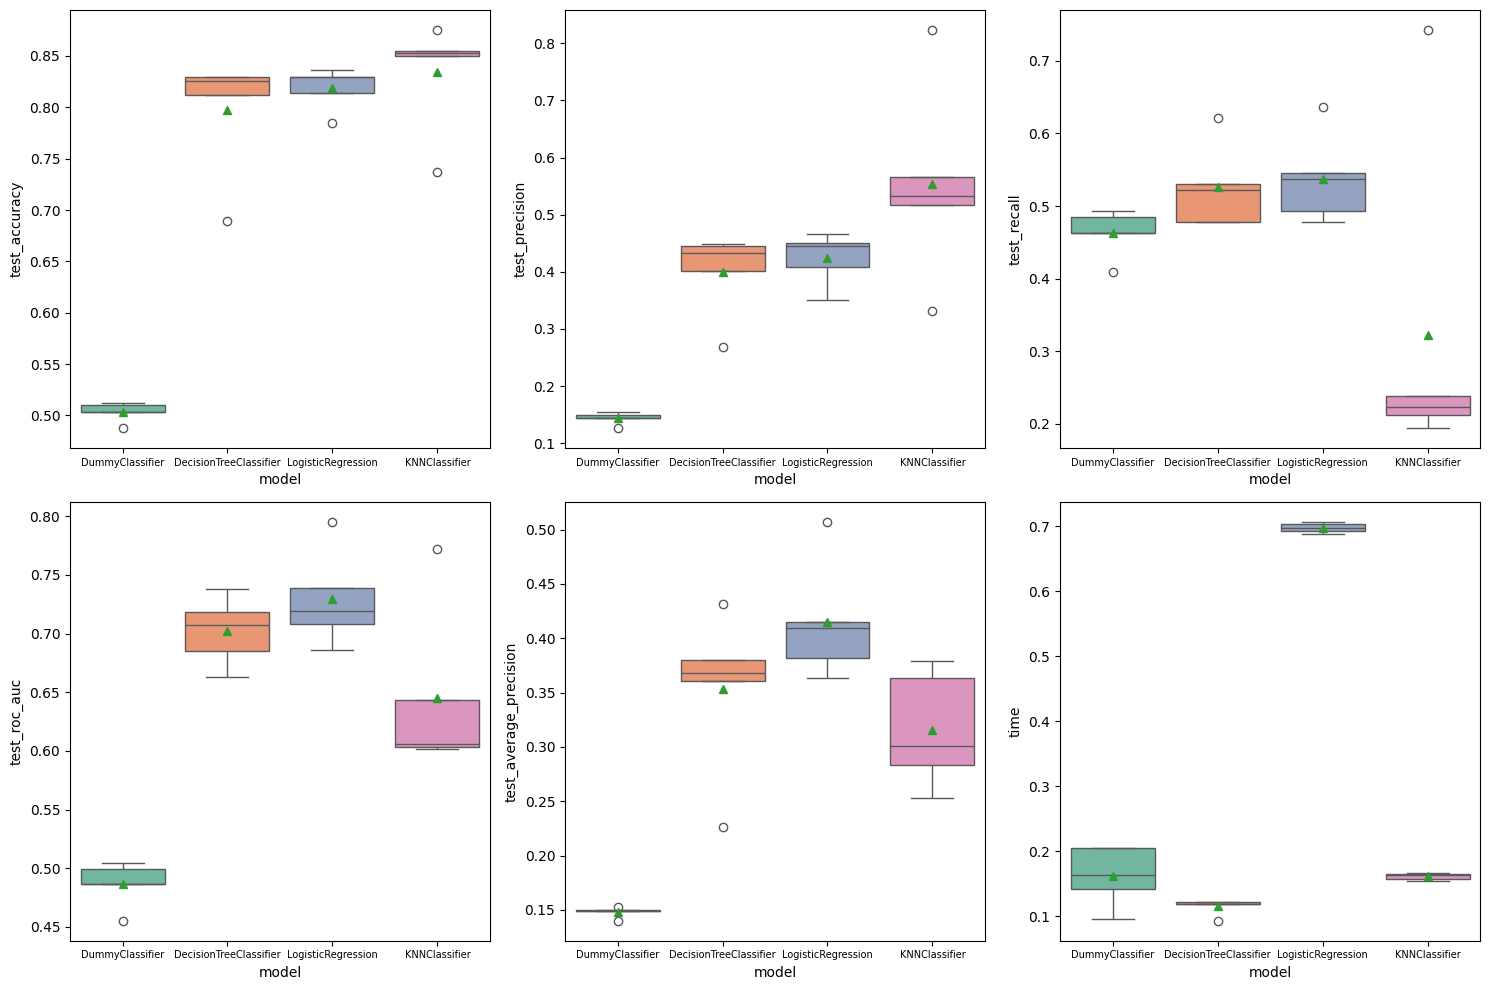

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), tight_layout=True)

cols = df_results.columns[3:].to_list()

unique_models = df_results_explode['model'].nunique()
palette = sns.color_palette("Set2", unique_models)

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(x='model', y=col, data=df_results_explode, ax=ax, showmeans=True, palette=palette, hue='model', legend=False)
    
    ax.tick_params(axis='x', labelsize=7)

plt.show()